In [12]:
from carla import Benchmark
from IPython.display import display
import carla.evaluation.catalog as evaluation_catalog
from carla.data.catalog import OnlineCatalog
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog
import shap 
from sklearn.preprocessing import OrdinalEncoder
from carla.data.causal_model import CausalModel
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from carla.data.catalog import CsvCatalog
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

In [13]:
scm = CausalModel("credit")

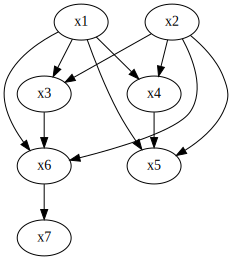

In [14]:
scm.cgm.draw()

In [15]:

dataset = scm.generate_dataset(1000)
dataset.df.to_csv('credit_synthetic.csv',index=False)
display(dataset.df)

,label,x1,x2,x3,x4,x6,x5,x7
0,0.0,1.0,-2.902481,-0.259092,-1.513706,-0.030344,6.002611,-2.461659
1,1.0,0.0,5.403381,-0.085550,1.741670,2.484693,-4.652789,-5.485265
2,0.0,0.0,3.997248,-0.048208,-1.353284,0.573378,-5.767892,3.052528
3,0.0,1.0,-3.174401,-0.292505,-0.470317,1.087564,-2.402285,-0.389992
4,1.0,1.0,10.919205,0.029335,5.347376,3.754266,8.375104,-6.530874
...,...,...,...,...,...,...,...,...
995,0.0,1.0,-8.909726,-0.173249,1.299552,1.940348,0.567712,-6.381265
996,0.0,1.0,-8.607962,-0.106987,-1.927606,1.038433,-5.809660,-9.850771
997,0.0,0.0,0.305859,0.017707,0.420934,-0.284123,-3.568457,-9.730227
998,1.0,0.0,1.393263,-0.357770,-2.334054,-0.804596,-6.652649,-6.217533


In [16]:
'''Build Dataset for Wachter'''
import pandas as pd
# Load Data 
dataframe = pd.read_csv('./credit_synthetic.csv')
continuous = dataframe.drop(columns=['label']).columns

dataset = CsvCatalog(file_path="credit_synthetic.csv",
                     continuous=continuous,
                     categorical=[],
                     immutables=[],
                     target='label')

In [17]:
#Model 

training_params = {"lr": 0.01, "epochs": 3, "batch_size": 16, "hidden_size": [18, 9, 2]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)


balance on test set 0.49866666666666665, balance on test set 0.504
Epoch 0/2
----------
train Loss: 0.6382 Acc: 0.6267

test Loss: 0.5733 Acc: 0.7360

Epoch 1/2
----------
train Loss: 0.5014 Acc: 0.7813

test Loss: 0.4927 Acc: 0.7840

Epoch 2/2
----------
train Loss: 0.4499 Acc: 0.7867

test Loss: 0.4537 Acc: 0.7960



In [18]:
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:25]

display(test_factual)

,label,x1,x2,x3,x4,x6,x5,x7
0,0.0,1.0,0.280668,0.180407,0.714679,0.491836,0.800338,0.420999
3,0.0,1.0,0.277154,0.134130,0.750693,0.554459,0.562781,0.474732
5,0.0,1.0,0.189251,0.842570,0.682972,0.513430,0.587484,0.390053
6,0.0,0.0,0.313873,0.452390,0.735457,0.305412,0.422379,0.643875
11,0.0,1.0,0.224892,0.413292,0.849620,0.565991,0.782869,0.265015
13,0.0,0.0,0.248905,0.107874,0.738908,0.329260,0.510215,0.438676
14,0.0,1.0,0.278314,0.444343,0.778629,0.362722,0.692222,0.335185
15,0.0,0.0,0.170214,0.216333,0.633492,0.483837,0.376576,0.327820
19,0.0,1.0,0.152797,0.532923,0.708625,0.439896,0.601508,0.315193
21,0.0,1.0,0.114695,0.321509,0.668369,0.348052,0.538288,0.470774


In [19]:
hyperparams = {"loss_type": "BCE"}

recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
cfs = recourse_method.get_counterfactuals(test_factual)


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Count

In [20]:
def get_pred_from_causal(scm,values,cf_label, mapping_dict):
    #TODO change everything hard coded
    values['target']=cf_label
    def _get_noise_string(node):
        def _get_node_id(node):
            return node[1:]
        if not node[0] == "x":
            raise ValueError
        return "u" + _get_node_id(node)
    exogenous_variables = np.concatenate(
        [
            np.array(values[mapping_dict[node]]).reshape(-1, 1)
            for node in scm.get_topological_ordering("exogenous")
        ],
        axis=1,
    )
    exogenous_variables = pd.DataFrame(
        exogenous_variables, columns=scm.get_topological_ordering("exogenous")
    )

    endogenous_variables = exogenous_variables.copy()
    endogenous_variables = endogenous_variables.rename(
        columns=dict(
            zip(
                scm.get_topological_ordering("exogenous"),
                scm.get_topological_ordering("endogenous"),
            )
        )
    )
    # used later to make sure parents are populated when computing children
    endogenous_variables.loc[:] = np.nan
    for node in scm.get_topological_ordering("endogenous"):
        parents = scm.get_parents(node)
        if endogenous_variables.loc[:, list(parents)].isnull().values.any():
            raise ValueError(
                "parents in endogenous_variables should already be occupied"
            )
        endogenous_variables[node] = scm.structural_equations_np[node](
            exogenous_variables[_get_noise_string(node)],
            *[endogenous_variables[p] for p in parents],
        )
    labels=endogenous_variables['x7'][0]
    return labels

In [21]:
mapping_dict={ 
    # Gender
      'u1': 'x1',
      # Age
      'u2': 'x2',
      # Education
      'u3': 'x3',
      # Loan amount
      'u4':'x4',
      # Loan duration
      'u5': 'x5',
      # Income
      'u6': 'x6',
      # Savings
      'u7':'x7',
}

In [22]:
from carla.data import causal_model
from carla.evaluation import remove_nans
from carla.evaluation.api import Evaluation
class Sematic(Evaluation):
    """
    """

    def __init__(self, ml_model, causal_graph,mapping_dict):
        self.ml_model= ml_model
        self.causal_graph=causal_graph
        self.mapping_dict=mapping_dict
    def get_evaluation(self,factuals: np.ndarray, counterfactuals: np.ndarray):
        # generate data 
        cf_label=self.ml_model.predict(np.array(counterfactuals.values).reshape(-1,counterfactuals.values.shape[-1]))
        cf_label=np.argmax(cf_label)
        causal_label=get_pred_from_causal(self.causal_graph,counterfactuals,cf_label, self.mapping_dict)
        print(cf_label)
        if cf_label ==causal_label:
            return pd.DataFrame([[1]], columns=["semantic"])
        else: 
            return pd.DataFrame([[0]], columns=["semantic"])
''' 
Analysis
Probitlity Distributions 
Histogram True Positive, False Positives 
'''
'''
Parts of counterfactuals actually change 
1hop and 2 hop relations 
'''
'''Histogram Features / true Positive / false Positive'''
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it
benchmark = Benchmark(ml_model, recourse_method, factuals)

# now you can decide if you want to run all measurements
# or just specific ones.
evaluation_measures = [
    Sematic(ml_model,scm,mapping_dict)

]

results = benchmark.run_benchmark(evaluation_measures)
results


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Timeout - No Counterfactual Explanation Found [wachter.py wachter_recourse]


In [ ]:
import seaborn as sns 
# Data Distribution
id_comp= np.where(results['semantics']==1)
id_not_comp=np.where(results['semantics']==0)
cfs_complient=cfs[id_comp]
cfs_not_complient=[]

cfs_complient_predict=[]
cfs_not_complient_predict=[]
#Histogram 


In [ ]:
# Violin Plot 
